In [257]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import ipaddress
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import kerastuner as kt
import IPython

In [258]:
def to_int(x):
    return int(x, 16)

In [259]:
path = "./datasets/iot-network-intrusion-dataset_190919/Packets_integrated/"

# 파일 변환 코드

In [260]:
# names_list = [f for f in os.listdir(path) if f.endswith('.txt')]
# for txt in names_list:
#     packet = pd.read_csv(os.path.join(path, txt), sep="\n", header = None)
#     packet[packet[0].str.contains("Frame \(")] = "\f"
#     packet[0] = packet[0].str[:53]
#     packet = packet[0].str.split("  ", expand=True)
#     packet = packet[[0, 1]]
#     packet = pd.DataFrame(packet.to_string(header=None, index=False).split("\f"))
#     print("Almost Done!")
#     packet[0]=packet[0].str.lstrip()
#     packet[0] = packet[0].str.replace("\n", " ")
#     for _ in range(10):
#         packet[0] = packet[0].str.replace("  ", " ")
#     packet[0] = packet[0].str[:222]
#     packet = packet[0].str.split(" ", expand=True)
#     packet=packet.fillna("00")
#     packet = packet.drop(columns=[0, 17, 34, 51, 68, 71])
#     packet=packet.replace("","00")
#     packet.to_csv(os.path.join(path, txt).replace(".txt","_hex")+".csv")
#     print(txt,"done")
# #     packet = packet.applymap(to_int)

# Reading files

In [261]:
hex_list = [f for f in os.listdir(path) if f.endswith('hex.csv')]

In [262]:
hex_list

['benign-dec_hex.csv',
 'dos-synflooding_hex.csv',
 'mirai-ackflooding_hex.csv',
 'mirai-hostbruteforce-1,3,5_hex.csv',
 'mirai-hostbruteforce-2,4_hex.csv',
 'mirai-httpflooding_hex.csv',
 'mirai-udpflooding_hex.csv',
 'mitm_hex.csv',
 'scan-hostport_1_hex.csv',
 'scan-hostport_2_hex.csv',
 'scan-hostport_3_hex.csv',
 'scan-hostport_4_hex.csv',
 'scan-hostport_5_hex.csv',
 'scan-hostport_6_hex.csv',
 'scan-portos_hex.csv']

In [263]:
dict_names=hex_list.copy()
csv_list=hex_list.copy()
for i in range(len(hex_list)):
    dict_names[i] = hex_list[i].replace("_hex.csv","")
    csv_list[i] = hex_list[i].replace("_hex","")

In [264]:
dict_names

['benign-dec',
 'dos-synflooding',
 'mirai-ackflooding',
 'mirai-hostbruteforce-1,3,5',
 'mirai-hostbruteforce-2,4',
 'mirai-httpflooding',
 'mirai-udpflooding',
 'mitm',
 'scan-hostport_1',
 'scan-hostport_2',
 'scan-hostport_3',
 'scan-hostport_4',
 'scan-hostport_5',
 'scan-hostport_6',
 'scan-portos']

In [265]:
csv_list

['benign-dec.csv',
 'dos-synflooding.csv',
 'mirai-ackflooding.csv',
 'mirai-hostbruteforce-1,3,5.csv',
 'mirai-hostbruteforce-2,4.csv',
 'mirai-httpflooding.csv',
 'mirai-udpflooding.csv',
 'mitm.csv',
 'scan-hostport_1.csv',
 'scan-hostport_2.csv',
 'scan-hostport_3.csv',
 'scan-hostport_4.csv',
 'scan-hostport_5.csv',
 'scan-hostport_6.csv',
 'scan-portos.csv']

In [266]:
X_dict = {}
for i, packets in enumerate(hex_list):
    X_dict[dict_names[i]] = pd.read_csv(os.path.join(path, packets),index_col=0, dtype=str)
    X_dict[dict_names[i]] = X_dict[dict_names[i]].join(pd.read_csv(os.path.join(path,csv_list[i])),how="outer")

X_dict['mirai-hostbruteforce-1,3,5'] 이런 이름의 사전형으로 데이터프레임을 분류하였다

In [267]:
y_dict = {}
for key, value in enumerate(X_dict):
    y_dict[value] = pd.read_csv(os.path.join(path, value)+"_attacked.csv", header=None)[0][1:].apply(int)

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [268]:
for i in dict_names:
    print(i, len(X_dict[i]),"    attacked", len(y_dict[i]))

benign-dec 137396     attacked 0
dos-synflooding 141709     attacked 64646
mirai-ackflooding 313462     attacked 75632
mirai-hostbruteforce-1,3,5 273357     attacked 1636
mirai-hostbruteforce-2,4 179998     attacked 961
mirai-httpflooding 248294     attacked 10464
mirai-udpflooding 1187114     attacked 949284
mitm 194184     attacked 101885
scan-hostport_1 29352     attacked 1490
scan-hostport_2 37106     attacked 2701
scan-hostport_3 13555     attacked 1730
scan-hostport_4 7801     attacked 1707
scan-hostport_5 4760     attacked 2211
scan-hostport_6 6828     attacked 2401
scan-portos 211078     attacked 12970


# 4번째 줄의 i를 바꿔서 다변량 or 이중 분류에 맞는 라벨 값 생성할 것

In [269]:
label_dict={}
for i,k in enumerate(dict_names):
    label = np.zeros(len(X_dict[k]))
    label[y_dict[k]-1] = i
    label_dict[k] = label

In [270]:
label_dict["mirai-hostbruteforce-2,4"][label_dict["mirai-hostbruteforce-2,4"]==4]=3
label_dict["scan-hostport_1"][label_dict["scan-hostport_1"]==8]=4
label_dict["scan-hostport_2"][label_dict["scan-hostport_2"]==9]=4
label_dict["scan-hostport_3"][label_dict["scan-hostport_3"]==10]=4
label_dict["scan-hostport_4"][label_dict["scan-hostport_4"]==11]=4
label_dict["scan-hostport_5"][label_dict["scan-hostport_5"]==12]=4
label_dict["scan-hostport_6"][label_dict["scan-hostport_6"]==13]=4
label_dict["scan-portos"][label_dict["scan-portos"]==14]=8

In [271]:
binary_label_dict={}
for i,k in enumerate(dict_names):
    label = np.zeros(len(X_dict[k]))
    label[y_dict[k]-1] = 1
    ###               이부분에 i가 아닌 1이 붙었으므로 이 라벨값 사용시 이중분류기가 됨
    binary_label_dict[k] = label

In [273]:
X_reduced = {}
for i in X_dict.keys():
    X_dict[i]["SourcePort"] = (X_dict[i]["37"]+X_dict[i]["38"]).apply(to_int)
    X_dict[i]["DestinationPort"] = (X_dict[i]["39"]+X_dict[i]["40"]).apply(to_int)
    X_reduced[i] = pd.DataFrame()
    X_reduced[i]["SourcePort"] = X_dict[i]["SourcePort"]    
    X_reduced[i]["DestinationPort"] = X_dict[i]["DestinationPort"]
    X_reduced[i]["Source"] = X_dict[i]["Source"]        
    X_reduced[i]["Destination"] = X_dict[i]["Destination"]
    X_reduced[i]["Time"] = X_dict[i]["Time"]  
    X_reduced[i]["Protocol"] = X_dict[i]["Protocol"]            
    X_reduced[i]["Length"] = X_dict[i]["Length"]            

# Protocol역시 리벨 인코딩을 통해 추가
# Length역시 넣다 빼고 결과 보기

## 아래에서 원하는 공격의 인덱스를 넣어 데이터를 분류할것

In [274]:
for i,k in enumerate(dict_names):
    print(i, k)

0 benign-dec
1 dos-synflooding
2 mirai-ackflooding
3 mirai-hostbruteforce-1,3,5
4 mirai-hostbruteforce-2,4
5 mirai-httpflooding
6 mirai-udpflooding
7 mitm
8 scan-hostport_1
9 scan-hostport_2
10 scan-hostport_3
11 scan-hostport_4
12 scan-hostport_5
13 scan-hostport_6
14 scan-portos


In [275]:
flooding_list=[dict_names[0],dict_names[1], dict_names[2], dict_names[5], dict_names[6]]

In [276]:
all_list=["benign-dec", "dos-synflooding", "mirai-ackflooding", "mirai-hostbruteforce", "scan-hostport",
         "mirai-httpflooding", "mirai-udpflooding","mitm","scan-portos"]

In [277]:
def make_X(target_list):    
    X=pd.DataFrame([])
    for i in target_list:
        X = X.append(X_reduced[i], ignore_index=True)
    return X

In [278]:
def make_y(target_list, label):
    y=[]
    for i in target_list:
        y.extend(label[i])
################ label_dict대신 binary_label_dict 사용시 이중분류를 위한 라벨값 생성가능
    y = np.array(y)
    return y

In [279]:
X = make_X(dict_names)
y = make_y(dict_names, label_dict)
### label_dict와 binary_label_dict를 넣어주면 된다

In [280]:
pd.Series(y).value_counts()

0.0    1756276
6.0     949284
7.0     101885
2.0      75632
1.0      64646
8.0      12970
4.0      12240
5.0      10464
3.0       2597
dtype: int64

In [282]:
encoder = LabelEncoder()
encoder.fit(X["Source"].append(X["Destination"]))
X["Source"] = encoder.transform(X["Source"])
X["Destination"] = encoder.transform(X["Destination"])
encoder = LabelEncoder()
X["Protocol"] = encoder.fit_transform(X["Protocol"])


###  공격을 쪼개서 따로 사전에 보관하는 코드
### 병렬적으로 학습시킨 후 예측하는 모델의 정확도가 낮으므로 현재는 주석처리

In [130]:
# X_flooding={}
# y_flooding={}
# for i in flooding_list:
#     X_flooding[i] = X_reduced[i]
#     y_flooding[i] = label_dict[i]

In [131]:
# scaler = StandardScaler()
# X_flooding_scaled = {}
# for i in X_flooding:
#     X_flooding[i]["Source"] = encoder.transform(X_flooding[i]["Source"])
#     X_flooding[i]["Destination"] = encoder.transform(X_flooding[i]["Destination"])
#     X_flooding_scaled[i] = scaler.fit_transform(X_flooding[i])

In [133]:
print("X shape:", X.shape, "    attacked y len:",len(y[y!=0]),"\n")
for i,k in enumerate(dict_names):
    if i==0:
        print(k, "num:", len(y[y==i]))
    else:
        print(k,"attack num:", len(y[y==i]))

### 공격을 뭉쳐주면서 인덱스가 조금 수정됨 모든 공격에 대한 패킷 수 chk'는 끝났으므로 검토 필요 x

X shape: (2985994, 5)     attacked y len: 1229718 

benign-dec num: 1756276
dos-synflooding attack num: 64646
mirai-ackflooding attack num: 75632
mirai-hostbruteforce-1,3,5 attack num: 2597
mirai-hostbruteforce-2,4 attack num: 12240
mirai-httpflooding attack num: 10464
mirai-udpflooding attack num: 949284
mitm attack num: 101885
scan-hostport_1 attack num: 12970
scan-hostport_2 attack num: 0
scan-hostport_3 attack num: 0
scan-hostport_4 attack num: 0
scan-hostport_5 attack num: 0
scan-hostport_6 attack num: 0
scan-portos attack num: 0


In [284]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [285]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.25)

In [286]:
X_train_, X_valid_, y_train_, y_valid_ = X_train, X_valid, y_train, y_valid

In [287]:
scaler = StandardScaler()
X_train, X_valid = scaler.fit_transform(X_train), scaler.fit_transform(X_valid)

In [288]:
all_list

['benign-dec',
 'dos-synflooding',
 'mirai-ackflooding',
 'mirai-hostbruteforce',
 'scan-hostport',
 'mirai-httpflooding',
 'mirai-udpflooding',
 'mitm',
 'scan-portos']

In [289]:
dict_names

['benign-dec',
 'dos-synflooding',
 'mirai-ackflooding',
 'mirai-hostbruteforce-1,3,5',
 'mirai-hostbruteforce-2,4',
 'mirai-httpflooding',
 'mirai-udpflooding',
 'mitm',
 'scan-hostport_1',
 'scan-hostport_2',
 'scan-hostport_3',
 'scan-hostport_4',
 'scan-hostport_5',
 'scan-hostport_6',
 'scan-portos']

In [290]:
# labels = ["benign", "attacked"]
labels = all_list

# 라벨값은 이중분류와 다중분류를 구분해서 넣어줄 것
# 리스트 형식으로 넣지 않았다면 위에서 보고 하나씩 드래그해 올것

# LogisticRegression

In [33]:
### 성능이 낮으므로 사용하지 않음 결과를 보고 싶다면 위에서 flooding_
# model = LogisticRegression(warm_start=True)
# for i in X_flooding:
#     X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding_scaled[i],y_flooding[i], test_size=0.25)
#     model.fit(X_train_classified, y_train_classified)
# plot = plot_confusion_matrix(model, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues)

In [34]:
# pred_list = []
# pred_sum=[]
# for i in X_flooding:
#     model = LogisticRegression()
#     X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding_scaled[i],y_flooding[i], test_size=0.25)
#     model.fit(X_train_classified, y_train_classified)
#     pred_list.append(model.predict(X_valid))
# pred_sum = np.zeros(pred_list[0].shape)
# for i in range(len(pred_list)):
#     pred_sum += pred_list[i]
    
# pred = pred_sum>1
# cm = confusion_matrix(y_valid, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues)

In [35]:
# pred_list = []
# pred_sum=[]
# for i in X_flooding:
#     model = LogisticRegression()
#     X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding_scaled[i],y_flooding[i], test_size=0.25)
#     model.fit(X_train_classified, y_train_classified)
#     pred_list.append(model.predict_proba(X_valid))
# pred_sum = np.zeros(pred_list[0].shape)
# for i in range(len(pred_list)):
#     pred_sum += pred_list[i]
    
# pred = np.argmax(pred_sum, axis=1)
# cm = confusion_matrix(y_valid, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues)

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


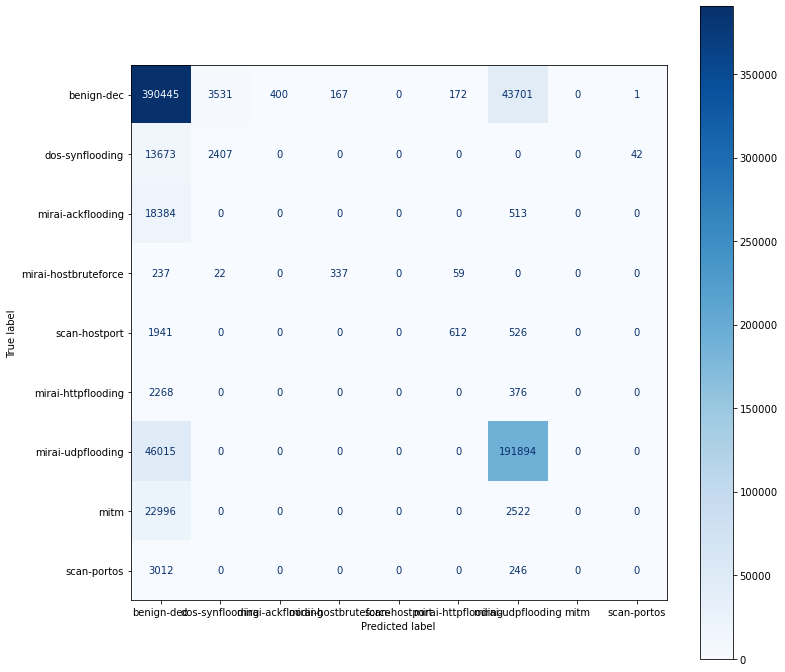

In [155]:
fig, ax = plt.subplots(figsize=(12, 12))
model_logistic = LogisticRegression(max_iter=5000)
model_logistic.fit(X_train_, y_train_)
plot_confusion_matrix(model_logistic, X_valid_, y_valid_, display_labels=labels, cmap=plt.cm.Blues, ax=ax)

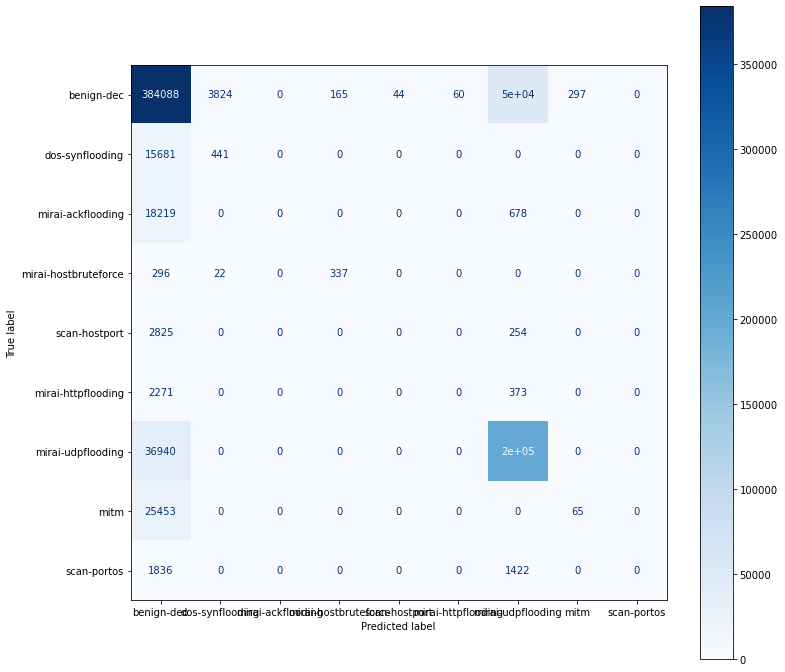

In [156]:
fig, ax = plt.subplots(figsize=(12, 12))
model_logistic = LogisticRegression(max_iter=5000)
model_logistic.fit(X_train, y_train)
plot_confusion_matrix(model_logistic, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues, ax=ax)

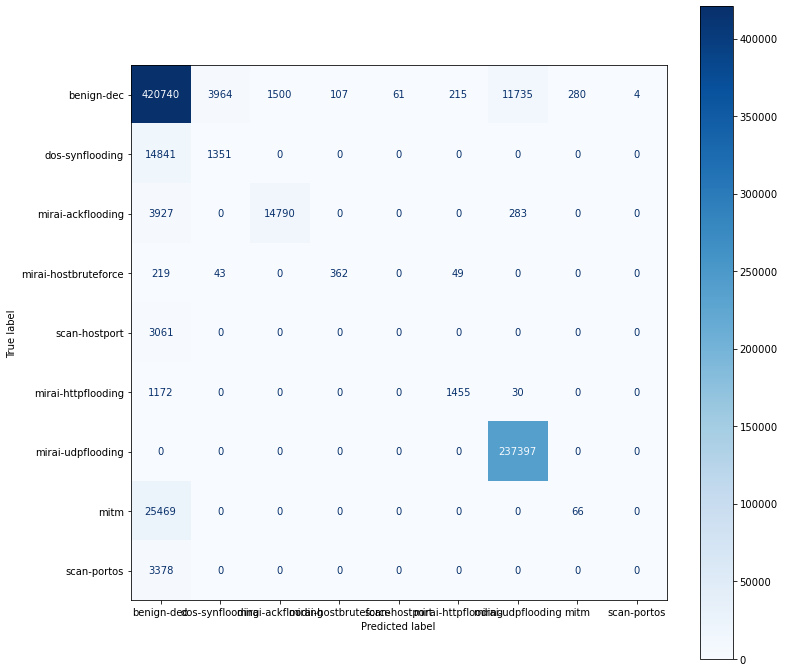

In [291]:
### 정보 추가
fig, ax = plt.subplots(figsize=(12, 12))
model_logistic = LogisticRegression(max_iter=5000)
model_logistic.fit(X_train, y_train)
plot_confusion_matrix(model_logistic, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues, ax=ax)

# KNN 

In [39]:
# pred_list = []
# pred_sum=[]
# for i in X_flooding:
#     model = KNeighborsClassifier()
#     X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding_scaled[i],y_flooding[i], test_size=0.25)
#     model.fit(X_train_classified, y_train_classified)
#     pred_list.append(model.predict(X_valid))
# pred_sum = np.zeros(pred_list[0].shape)
# for i in range(len(pred_list)):
#     pred_sum += pred_list[i]
    
# pred = pred_sum>1
# cm = confusion_matrix(y_valid, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues)

In [40]:
# pred_list = []
# pred_sum=[]
# for i in X_flooding:
#     model = KNeighborsClassifier()
#     X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding_scaled[i],y_flooding[i], test_size=0.25)
#     model.fit(X_train_classified, y_train_classified)
#     pred_list.append(model.predict_proba(X_valid))
# pred_sum = np.zeros(pred_list[0].shape)
# for i in range(len(pred_list)):
#     pred_sum += pred_list[i]
    
# pred = np.argmax(pred_sum, axis=1)
# cm = confusion_matrix(y_valid, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues)

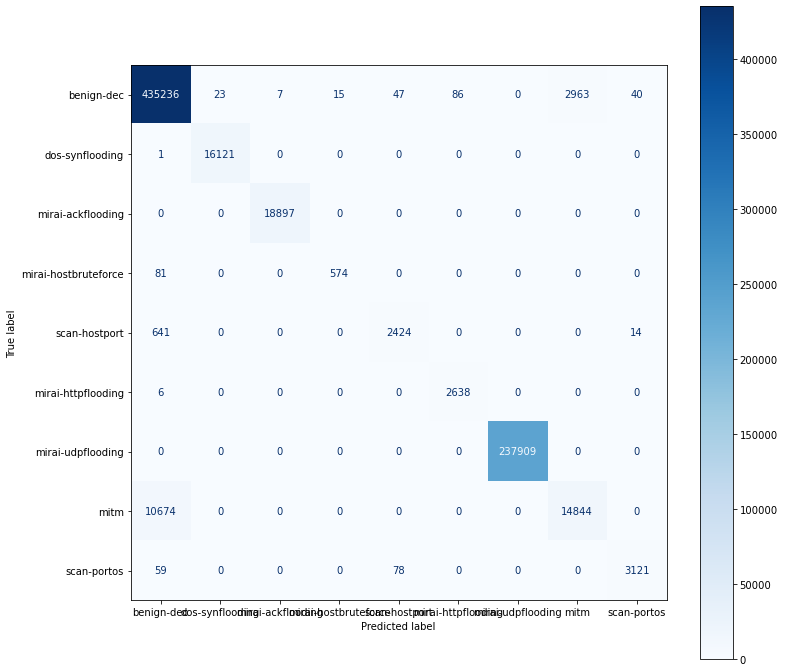

In [151]:
fig, ax = plt.subplots(figsize=(12, 12))
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train, y_train)
plot = plot_confusion_matrix(model_knn, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues, ax=ax)

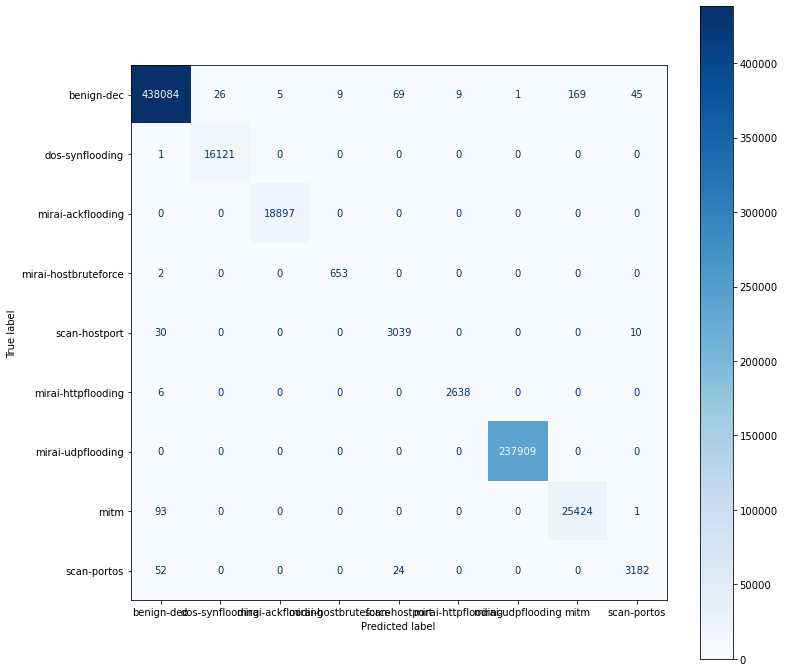

In [152]:
fig, ax = plt.subplots(figsize=(12, 12))
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train_, y_train_)
plot = plot_confusion_matrix(model_knn, X_valid_, y_valid_, display_labels=labels, cmap=plt.cm.Blues, ax=ax)

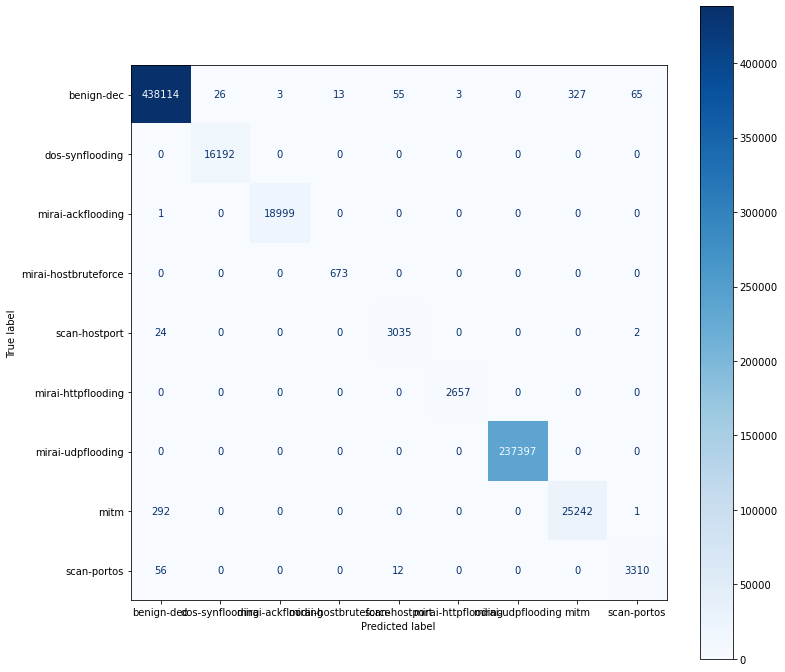

In [292]:
### 정보 추가
fig, ax = plt.subplots(figsize=(12, 12))
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train_, y_train_)
plot = plot_confusion_matrix(model_knn, X_valid_, y_valid_, display_labels=labels, cmap=plt.cm.Blues, ax=ax)

# RandomForest

In [41]:
# pred_list = []
# pred_sum=[]
# for i in X_flooding:
#     model = RandomForestClassifier()
#     X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding[i],y_flooding[i], test_size=0.25)
#     model.fit(X_train_classified, y_train_classified)
#     pred_list.append(model.predict(X_valid))
# pred_sum = np.zeros(pred_list[0].shape)
# for i in range(len(pred_list)):
#     pred_sum += pred_list[i]
    
# pred = pred_sum>1
# cm = confusion_matrix(y_valid, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues)

In [42]:
# pred_list = []
# pred_sum=[]
# for i in X_flooding:
#     model = RandomForestClassifier()
#     X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding[i],y_flooding[i], test_size=0.25)
#     model.fit(X_train_classified, y_train_classified)
#     pred_list.append(model.predict_proba(X_valid))
# pred_sum = np.zeros(pred_list[0].shape)
# for i in range(len(pred_list)):
#     pred_sum += pred_list[i]
    
# pred = np.argmax(pred_sum, axis=1)
# cm = confusion_matrix(y_valid, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues)

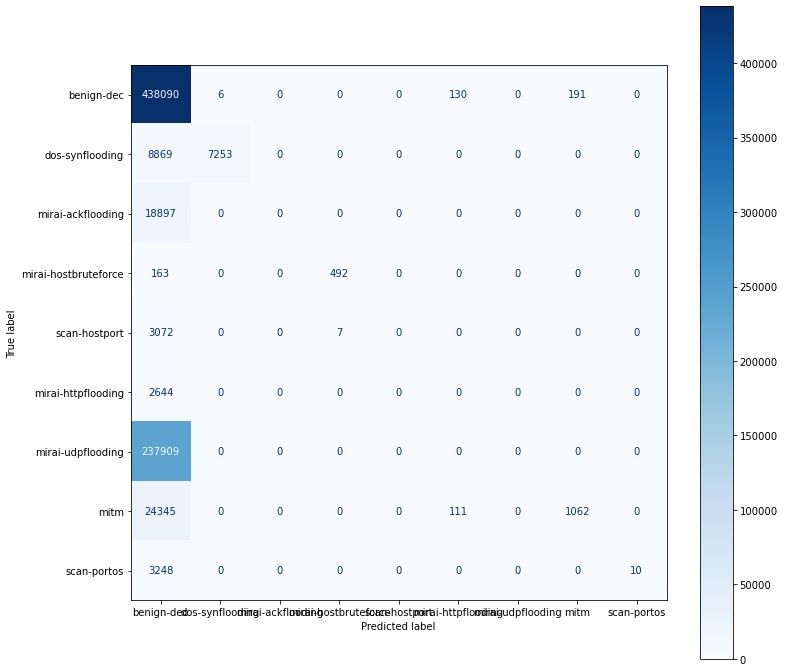

In [148]:
fig, ax = plt.subplots(figsize=(12, 12))
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
plot = plot_confusion_matrix(model_rf, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues, ax=ax)

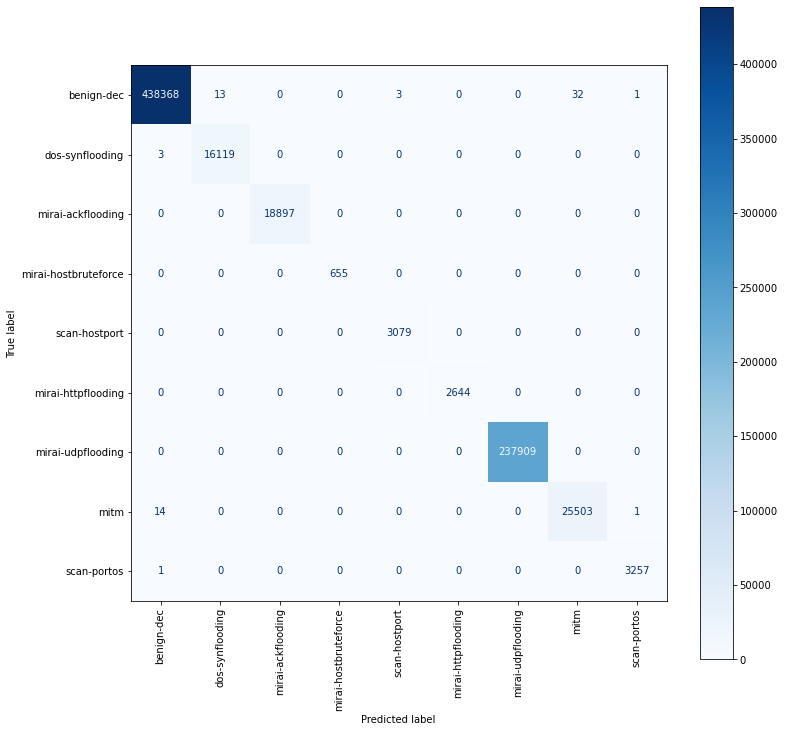

In [161]:
fig, ax = plt.subplots(figsize=(12, 12))
model_rf = RandomForestClassifier()
model_rf.fit(X_train_, y_train_)
plot = plot_confusion_matrix(model_rf, X_valid_, y_valid_, display_labels=labels, cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")

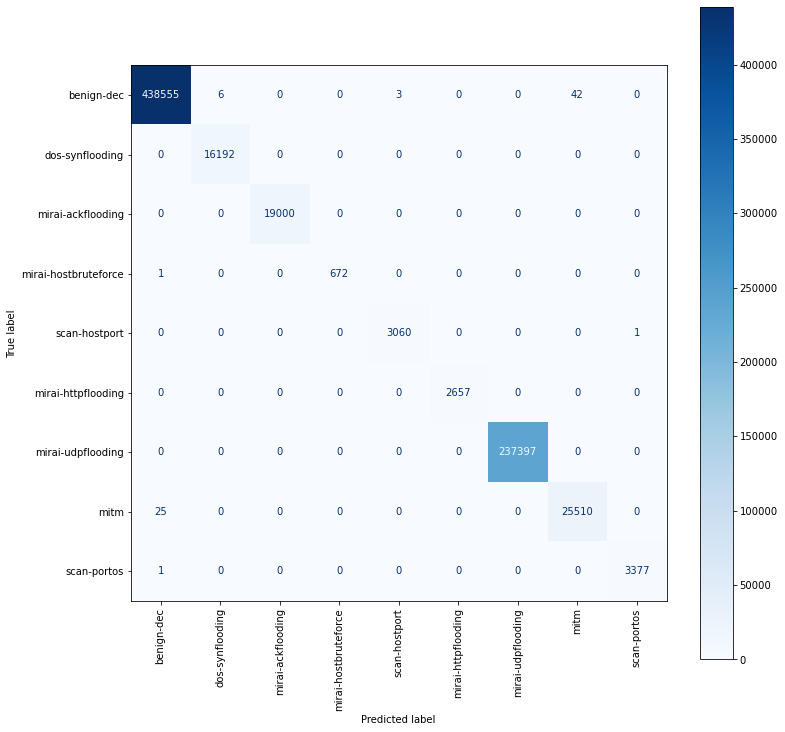

In [293]:
###정보 추가
fig, ax = plt.subplots(figsize=(12, 12))
model_rf = RandomForestClassifier()
model_rf.fit(X_train_, y_train_)
plot = plot_confusion_matrix(model_rf, X_valid_, y_valid_, display_labels=labels, cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")

In [239]:
def create_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=[X_train.shape[1]]))
    
    hp_units_1 = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    hp_units_2 = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    
    
    model.add(keras.layers.Dense(units=hp_units_1, activation="relu"))
    model.add(keras.layers.Dense(units=hp_units_2, activation="relu"))

    model.add(keras.layers.Dense(9, activation="softmax"))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3])
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  metrics=["accuracy"])
    return model
# history = model.fit(X_train, y_train, epochs=1, validation_data = (X_valid, y_valid), batch_size=64)

In [304]:
tuner = kt.RandomSearch( create_model, # HyperModel
                    objective='val_accuracy', # 최적화할 하이퍼모델
                    max_trials=20,
                    executions_per_trial=5, # 각 모델별 학습 회수
                    directory='my_dir', # 사용된 parameter 저장할 폴더
                    project_name='intro_to_kt') # 사용된 parameter 저장할 폴더

In [240]:
tuner = kt.Hyperband(create_model,
                     objective = 'val_accuracy', 
                     max_epochs = 20,
                     factor = 5,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json


In [241]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [305]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid), callbacks = [ClearTrainingOutput()])

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
print(best_hps.get("units"), best_hps.get("learning_rate"))

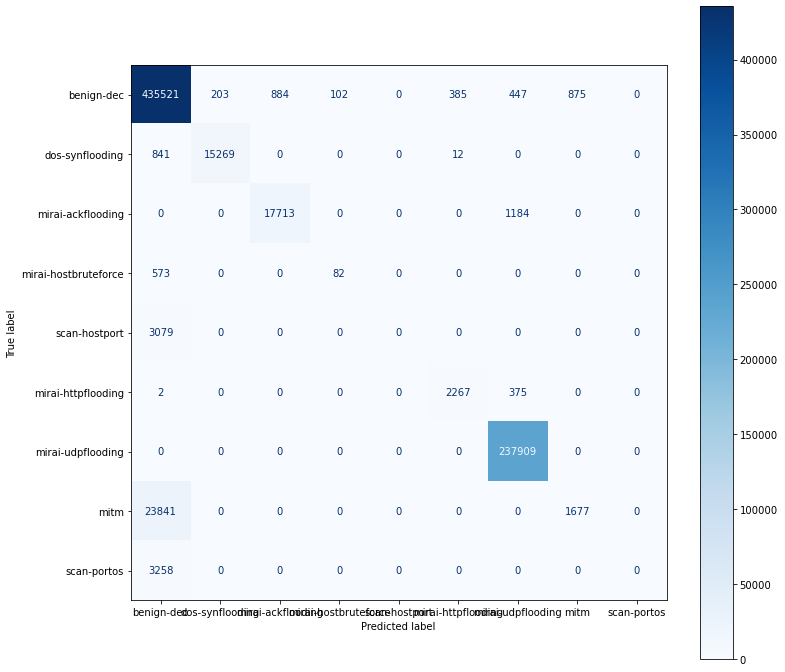

In [192]:
fig, ax = plt.subplots(figsize=(12, 12))
pred = model.predict_classes(X_valid)
cm=confusion_matrix(y_valid,pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")

In [ ]:
# hist_list = []
# # 노드개수 3개인것도 추가해주자
# for i in [3,5,10]:
#     model = keras.models.Sequential([
#         keras.layers.Dense(10, activation="tanh", input_shape=[X_train.shape[1]]),
#         keras.layers.Dense(10, activation="relu"),
#         keras.layers.Dense(7, activation="relu"),

#         keras.layers.Dense(5, activation="relu"),
#         keras.layers.Dense(5, activation="softmax")
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#     history = model.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid), batch_size=64)
#     hist_list.append(history) 

In [105]:
tanh_hist = []
for i in [3,5,10]:
    model = keras.models.Sequential([
        keras.layers.Dense(i, activation="tanh", input_shape=[X_train.shape[1]]),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid))
    tanh_hist.append(history) 

Train on 1417934 samples, validate on 472645 samples
Epoch 1/10
1417934/1417934 [==============================] - 137s 97us/sample - loss: 0.2547 - accuracy: 0.8983 - val_loss: 0.1700 - val_accuracy: 0.9454
Epoch 2/10
1417934/1417934 [==============================] - 140s 98us/sample - loss: 0.1475 - accuracy: 0.9454 - val_loss: 0.1349 - val_accuracy: 0.9451
Epoch 3/10
1417934/1417934 [==============================] - 139s 98us/sample - loss: 0.1278 - accuracy: 0.9459 - val_loss: 0.1229 - val_accuracy: 0.9461
Epoch 4/10
1417934/1417934 [==============================] - 131s 92us/sample - loss: 0.1186 - accuracy: 0.9468 - val_loss: 0.1150 - val_accuracy: 0.9472
Epoch 5/10
1417934/1417934 [==============================] - 134s 95us/sample - loss: 0.1122 - accuracy: 0.9475 - val_loss: 0.1104 - val_accuracy: 0.9478
Epoch 6/10
1417934/1417934 [==============================] - 123s 87us/sample - loss: 0.1088 - accuracy: 0.9479 - val_loss: 0.1077 - val_accuracy: 0.9481
Epoch 7/10
141793

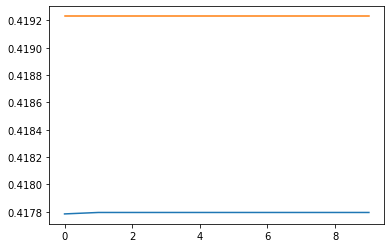

In [102]:
 plt.plot(hist_list[0].history['accuracy'])
plt.plot(hist_list[0].history['val_accuracy'])

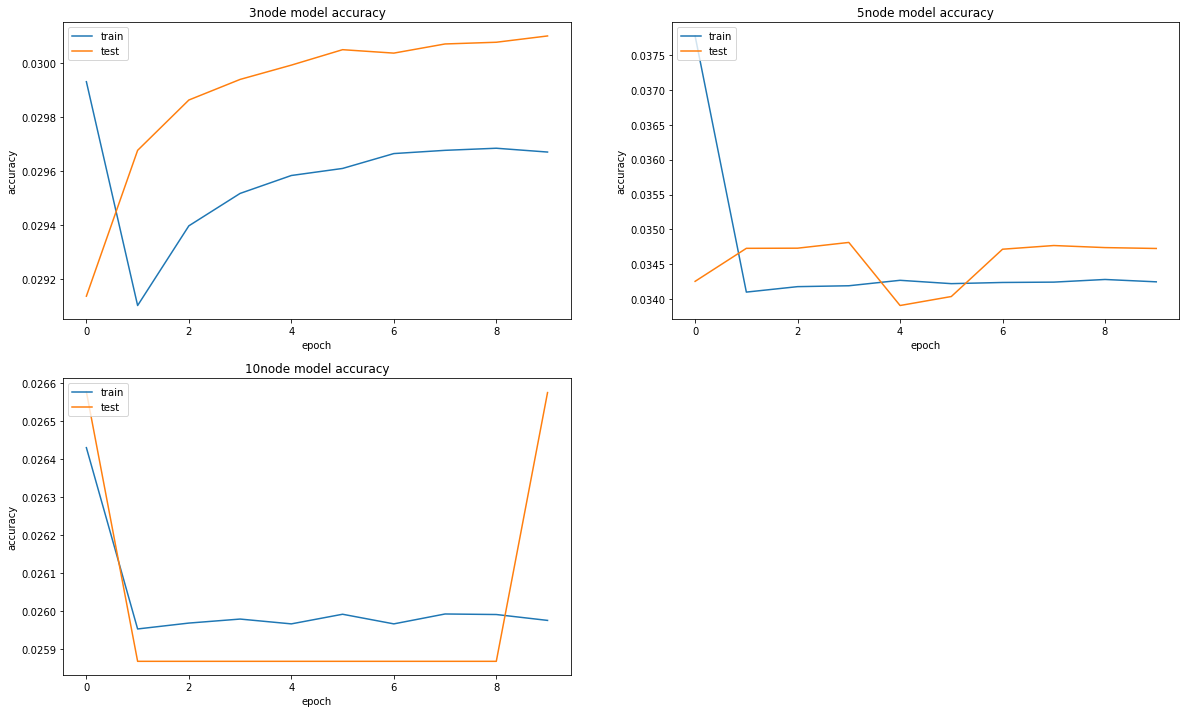

In [37]:
node_list = [3,5,10]
plt.figure(figsize=(20, 12))
for i in range(3):
    plt.subplot(2,2,i+1)    
    plt.plot(hist_list[i].history['accuracy'])
    plt.plot(hist_list[i].history['val_accuracy'])
    plt.title(str(node_list[i])+ 'node model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

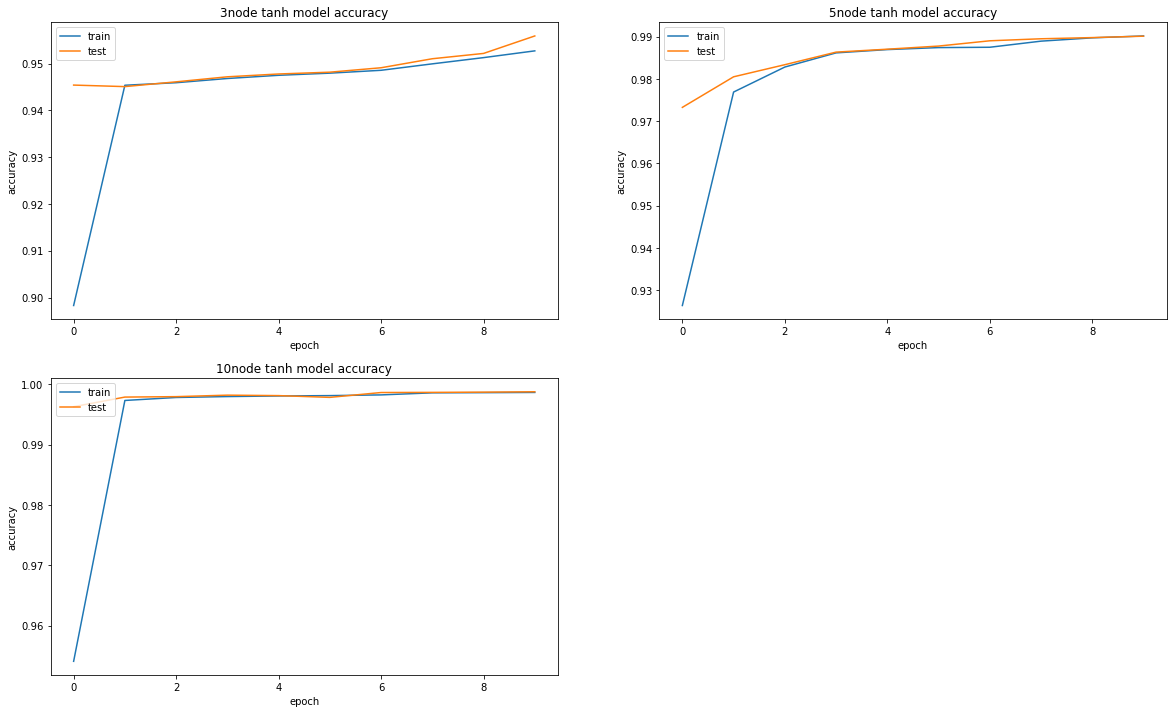

In [106]:
node_list = [3,5,10]
plt.figure(figsize=(20, 12))
for i in range(3):
    plt.subplot(2,2,i+1)    
    plt.plot(tanh_hist[i].history['accuracy'])
    plt.plot(tanh_hist[i].history['val_accuracy'])
    plt.title(str(node_list[i])+ 'node tanh model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

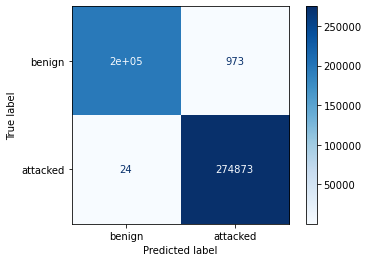

In [195]:
pred = hist_list[0].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

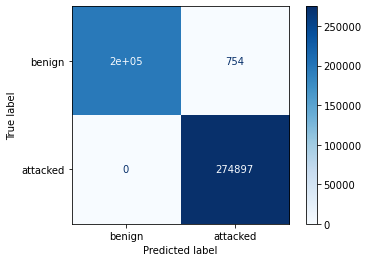

In [196]:
pred = hist_list[1].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

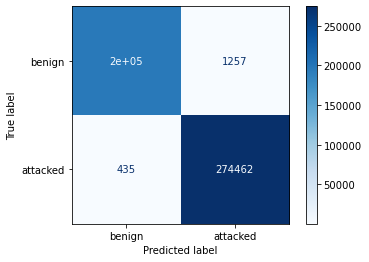

In [197]:
pred = hist_list[2].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

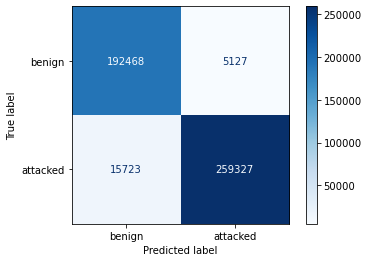

In [113]:
pred = tanh_hist[0].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

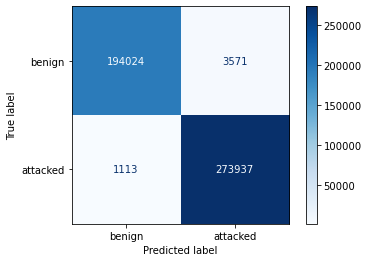

In [114]:
pred = tanh_hist[1].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

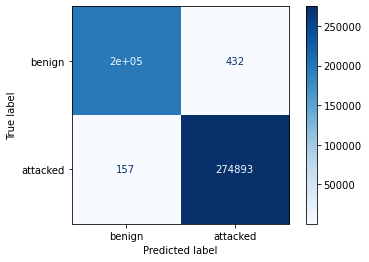

In [115]:
pred = tanh_hist[2].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)